## [실습] Human-in-the-loop 구조 실행하기

Human-in-the-loop는 LangGraph 어플리케이션을 작동중일 때, 그래프의 중간 과정에서 사용자의 응답을 요청하는 과정입니다.   

`interrupt`를 특정 시점에 실행하면, 해당 시점에서 실행이 중단되는데요.    


해당 노드에서 `Command(resume)`를 통해 재개할 수 있습니다.   

또한, `Command(goto)`는 다른 위치로 이동하기 위해 사용됩니다.

In [1]:
!pip install langgraph langchain langchain_google_genai langchain-tavily -q

LLM을 설정합니다.

In [1]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

llm.invoke("안녕")

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--70d1e7ca-8232-43c0-8d3a-d4a4d98c0c87-0', usage_metadata={'input_tokens': 3, 'output_tokens': 237, 'total_tokens': 240, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 229}})

중간 과정 확인을 위해, LangSmith를 연동합니다.
https://smith.langchain.com 에서 등록 후 작성합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

### 네이버 블로그 검색 Tool 구성하기
네이버의 검색 API를 이용해, 블로그 검색을 연결하겠습니다.   
(https://developers.naver.com/apps/#/register?defaultScope=search)

In [2]:
import os
import sys
import urllib.request
import json
from langchain_core.tools import tool

from typing_extensions import TypedDict, Literal, Annotated

headers = {
    'X-Naver-Client-Id': 'Ko6yIqbV2TOHq9rPH8tu',
    'X-Naver-Client-Secret': 'BvqX8mNtHu'
}

@tool
def search_blogs(query: str, display : int = 10, sort : Literal['sim', 'date'] = 'sim') -> list:
    """네이버 블로그 검색을 수행하여 검색 결과를 리스트로 반환합니다.
    query: 검색어
    display: 검색 결과 개수
    sort: sim(관련도순), date(시간순)
    """

    client_id = headers['X-Naver-Client-Id']
    client_secret = headers['X-Naver-Client-Secret']

    encText = urllib.parse.quote(query)
    url = f"https://openapi.naver.com/v1/search/blog?query={encText}&display={display}"

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)

    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if rescode == 200:
        response_body = response.read()
        data = json.loads(response_body.decode('utf-8'))

        # 필요한 데이터 추출
        blog_list = [
            {
                "title": item["title"].replace("<b>", "").replace("</b>", ""),  # 태그 제거
                "link": item["link"],
                "description": item["description"].replace("<b>", "").replace("</b>", ""),
                "postdate": item["postdate"]
            }
            for item in data.get("items", [])
        ]

        return blog_list
    else:
        return ['에러 발생, 다른 검색어로 다시 시도하세요.']


tool_list = [search_blogs]
llm_with_tools = llm.bind_tools(tool_list)

In [6]:
llm_with_tools.invoke("안녕")

AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--9560c08b-77c3-44b6-8a0d-f5c95a858c3d-0', usage_metadata={'input_tokens': 118, 'output_tokens': 8, 'total_tokens': 126, 'input_token_details': {'cache_read': 0}})

툴을 구성한 뒤, State와 노드를 구성합니다.

In [3]:
from langgraph.graph.message import add_messages

# query와 messages를 저장
class State(TypedDict):
    query : str
    messages : Annotated[list, add_messages]

In [4]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# 메시지 입력
def get_user_input(state):
    human_message = input()
    return {'messages':[HumanMessage(content = human_message)]}

def agent(state):
    system_message = SystemMessage(content='''당신은 검색 및 요약 챗봇입니다.
사용자의 질문을 해결하기 위해 검색 툴을 사용하고, 해당 결과를 바탕으로 답변하세요.
요청을 해결한 다음에는 마지막에 '감사합니다! 챗봇을 종료합니다!'를 출력하세요.''')

    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}


def run_tool(state):
    new_messages = []
    last_message = state["messages"][-1]

    tools = {tool.name:tool for tool in tool_list}

    tool_calls = last_message.tool_calls

    for tool_call in tool_calls:
        tool = tools[tool_call["name"]]
        result = tool.invoke(tool_call)
        # ToolMessage
        new_messages.append(result)
    return {"messages": new_messages}


툴을 실행하기 전, `human_review`를 통과하도록 구성합니다.

In [31]:
# Typing Hint를 연결하면 Graph에 표시됨
def human_review(state) -> Command[Literal["agent", "run_tool"]]:

    # !!중요!!
    # Human_review가 실행되는 상황은 언제일까요?
    # Tool을 실행하기 전이므로, 이 상태의 Context는
    # 항상 [..., AIMessage(content, tool_calls)]

    last_message = state["messages"][-1] # tool call 포함된 AIMessage
    tool_call = last_message.tool_calls[-1]

    # inturrupt로 중단된 결과는 Command를 통해 재개
    human_review = interrupt(
        {
            "question": "이대로 진행할까요?",
            "tool_call": tool_call,
        }
    )
    review_action = human_review["action"]
    review_data = human_review.get("data")

    print('Decision:', review_action, '\n Content:', review_data)


    # 그대로 진행하는 경우, run_tool로 진입
    if review_action == "continue":
        return Command(goto="run_tool")

    # update가 필요한 경우, review_data를 args에 넣고 run_tool로 진입
    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],

                    "args": review_data,
                    # 새로운 입력
                }
            ],
            "id": last_message.id,
            # 메시지 id를 동일하게 설정해 Override
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})


    # Feedback: 단순 언어로 피드백을 전달하고 싶은 경우
    elif review_action == "feedback":

        # Tool Call 요청을 새로운 유저 메시지로 대체합니다.

        new_human_message = HumanMessage(content = review_data,
        id = last_message.id)

        return Command(goto="agent", update={"messages": [new_human_message]})


def route_after_llm(state) -> Literal[END, "get_user_input", "human_review"]:

    last_message = state['messages'][-1]
    # 마지막 메시지: tool calling
    # 2025.10.26 업데이트: Gemini의 Thinking 모델(2.5 이후)에는
    # Tool Calling 이후의 messages에 signature가 포함되어 형식이 달라집니다.
    last_message_content = last_message.content

    if not last_message.tool_calls:
        if '감사합니다! 챗봇을 종료합니다!' in last_message_content:
            return END
        elif isinstance(last_message_content[0], dict) and 'text' in last_message_content[0] and '감사합니다! 챗봇을 종료합니다!' in last_message_content[0]['text']:
            return END
        return 'get_user_input'
    else:
        return "human_review"


In [32]:
builder = StateGraph(State)
builder.add_node(get_user_input)
builder.add_node(agent)
builder.add_node(run_tool)
builder.add_node(human_review)

builder.add_edge(START, "get_user_input")
builder.add_edge('get_user_input', "agent")
builder.add_conditional_edges("agent", route_after_llm)
builder.add_edge("run_tool", "agent")

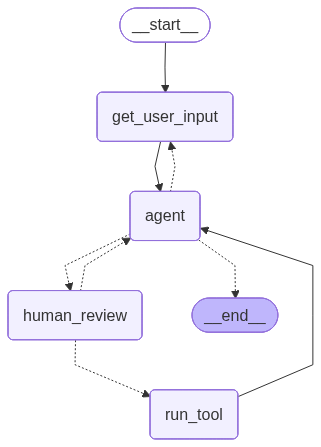

In [33]:
memory = MemorySaver()

graph = builder.compile(checkpointer=memory)
# 중간 상태 저장을 위해 체크포인터가 필요합니다!
graph

In [34]:
from rich import print as rprint
# Input
initial_input = {"messages": []}

# Thread
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    rprint(event)
    rprint("\n")

{
    'get_user_input': {
        'messages': [
            HumanMessage(
                content='역삼역 근처 커피 맛있는 카페 알려줘',
                additional_kwargs={},
                response_metadata={},
                id='df4e5b32-844f-44d5-ab78-ed0186673704'
            )
        ]
    }
}

{
    'agent': {
        'messages': [
            AIMessage(
                content='',
                additional_kwargs={
                    'function_call': {
                        'name': 'search_blogs',
                        'arguments': '{"query": "\\uc5ed\\uc0bc\\uc5ed \\ucee4\\ud53c \\ub9db\\uc9d1"}'
                    }
                },
                response_metadata={
                    'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
                    'finish_reason': 'STOP',
                    'model_name': 'gemini-2.5-flash',
                    'safety_ratings': [],
                    'grounding_metadata': {},
                    'model_provider': 'google_genai'
                },
                id='lc_run--2938f215-f181-47c1-aab9-593e79f6710a-0',
                tool_calls=[
                    {
                        'name': 'search_blogs',
                        'args': {'query': '역삼역 커피 맛집'},
                        'id': 'b2f8916e-62e5-4c9f-b875-1856f498b42b',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 187,
                    'output_tokens': 153,
                    'total_tokens': 340,
                    'input_token_details': {'cache_read': 0},
                    'output_token_details': {'reasoning': 133}
                }
            )
        ]
    }
}

{
    '__interrupt__': (
        Interrupt(
            value={
                'question': '이대로 진행할까요?',
                'tool_call': {
                    'name': 'search_blogs',
                    'args': {'query': '역삼역 커피 맛집'},
                    'id': 'b2f8916e-62e5-4c9f-b875-1856f498b42b',
                    'type': 'tool_call'
                }
            },
            id='b092e1ee23fd9d50792d10f2b6dcf2fc'
        ),
    )
}

`__interrupt__`가 구성되면, 사용자 확인을 위해 중단된 상황입니다.

In [35]:
print("graph 현재 상황")
print(graph.get_state(thread).next)

graph 현재 상황
('human_review',)


`human_review`에 기록된 값 중 하나를 입력하여 작업을 재개합니다.   
`Command`의 resume으로 값을 보낼 수 있습니다.

1. `{"action": "continue"}`
2. `{"action": "update", "data": {"query": "새로운 쿼리"}}`
3. `{"action": "feedback", "data": {"query": "전달할 피드백 내용"}}`

### Continue
run_tool으로 진행합니다.

In [36]:
for event in graph.stream(

    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: continue 
 Content: None
{'human_review': None}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "역삼역 카페 디저트 쿠키 맛집 커피 맛있는 미니말레 커피뢰스터", "link": "https://blog.naver.com/haha4090/223820807313", "description": "역삼역 카페 디저트 쿠키 맛집 커피 맛있는 미니말레 커피뢰스터 안녕하세요! 오늘은 얼마 전 친구들과 다녀왔던 역삼역 커피 맛집을 소개해 드릴게요! 미니말레 커피뢰스터는 직접 로스팅한 스페셜티 커피와... ", "postdate": "20250403"}, {"title": "역삼역 카페 미니말레 커피뢰스터 커피 맛집 데이트", "link": "https://blog.naver.com/grb_080913/224003692668", "description": "있어 역삼역 커피 맛집다운 퀄리티라는 생각이 들었다 견과류의 고소함과 단맛이 느껴지는 맛... 방문해보세요  #역삼맛집 #카페 #카페추천 #맛집 #맛집추천 #역삼카페 #역삼역카페 #역삼역커피 #역삼역데이트... ", "postdate": "20250911"}, {"title": "역삼역 커피 미니말레 커피뢰스터 스페셜티 카페 수제디저트 맛집", "link": "https://blog.naver.com/aboutclaire/223232474188", "description": "만나러 역삼 방문 맛있는 역삼역 커피 마실만한 곳 찾아보다가 평소 가보고 싶었던 카페 미니말레... 싱글오리진) 커피 소비국 1위 핀란드에서 맛본 라테를 재현한 역삼역 커피 맛집의 헬싱키 라떼는 미니말레에... ", "postdate": "20231010"}, {"title": "강남 감성 카페 역삼역 데이트로 좋은 커피 맛집 미니말레", "link": "https://blog.naver.com/rlaalsgml357/223551625

### Update
Command로 전달되는 값을 받아 갱신합니다.   
검색 쿼리를 수정하기로 설정했으므로, 바뀐 쿼리를 전달하게 됩니다.

In [37]:
thread = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'get_user_input': {'messages': [HumanMessage(content='이번 달 새로 개봉한 영화 알려줘', additional_kwargs={}, response_metadata={}, id='86ea60e9-64b4-44b8-a121-bfcc3e052d41')]}}


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search_blogs', 'arguments': '{"display": 5, "sort": "date", "query": "\\uc774\\ubc88 \\ub2ec \\uc0c8\\ub85c \\uac1c\\ubd09\\ud55c \\uc601\\ud654"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--b82dd54e-8d6b-4122-9e99-1ab689fef7fa-0', tool_calls=[{'name': 'search_blogs', 'args': {'display': 5, 'sort': 'date', 'query': '이번 달 새로 개봉한 영화'}, 'id': '2cc6f99b-7b7a-40c4-9171-7e7cf45c8182', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185, 'output_tokens': 250, 'total_tokens': 435, 'input_token_details': {'cache_read': 0}, 'output_token_deta

In [38]:
for event in graph.stream(
    Command(resume={"action": "update", "data": {"query": "2025년 10월 개봉 영화"}}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: update 
 Content: {'query': '2025년 10월 개봉 영화'}
{'human_review': {'messages': [{'role': 'ai', 'content': '', 'tool_calls': [{'id': '2cc6f99b-7b7a-40c4-9171-7e7cf45c8182', 'name': 'search_blogs', 'args': {'query': '2025년 10월 개봉 영화'}}], 'id': 'lc_run--b82dd54e-8d6b-4122-9e99-1ab689fef7fa-0'}]}}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "영화 보스 2025년 10월 개봉 영화", "link": "https://blog.naver.com/jhy703011/224050292149", "description": "https://naver.me/Fm3AZoKh #영화보스 #2025년영화 #코미디 #액션 #줄거리 #리뷰 #개봉일 #나무위키 #영화추천 #보스 #10월개봉영화 #보스영화 #코미디영화 #코메디영화 #한국영화보스 #한국코미디영화... ", "postdate": "20251022"}, {"title": "2025년 10월 개봉 영화 기대작", "link": "https://blog.naver.com/luckyhyh/224022122539", "description": "사진출처:네이버영화, 예고편캡쳐, IMDB #2025년10월개봉작 #2025년10월개봉영화 #2025년10월영화 #2025년10월개봉예정영화 #2025년10월개봉예정기대작 #개봉예정작 #10월개봉영화", "postdate": "20250926"}, {"title": "2025년 10월 개봉예정영화... 뭐가 좀 많네 싶은 10월 개봉 영화", "link": "https://blog.naver.com/lubkhaki/224022855659", "description": "2025년 10월 개

### feedback   
구현 방식에 따라, 자연어로 구성된 피드백을 전달하면 이를 반영하여 수정할 수도 있습니다.

In [41]:
thread = {"configurable": {"thread_id": "4"}}

for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

{'get_user_input': {'messages': [HumanMessage(content='판타지 시리즈로 넷플릭스에서 괜찮은 작품 추천해줘', additional_kwargs={}, response_metadata={}, id='28b8d815-b34d-4540-80b7-0cd2ab2015a2')]}}


{'agent': {'messages': [AIMessage(content=[{'type': 'text', 'text': '넷플릭스 판타지 시리즈 추천에 대한 블로그 글들을 검색해 보겠습니다. 잠시만 기다려 주세요!', 'extras': {'signature': 'CocOAdHtim+ckSJxNbKZif1ufGR0s+dXg/H7fk6OPKLu6Dcx9mpXCQC9C1JLcBItwfOYegG9ESgd5x44e7O3mS8dMlMogSw6xPT4s2qtmPan6DmMLGR5IkWpXniFD5agpkH1QY4NHj395m6R2DglIOdeKxZsXYRI+yguWzH9Jcex9XCCa6mi+C5sAcpBZzroBR+39eolFcOnHngyvI6vwAgB1hasSXGjOC8kA22xS6gf5wM85Y76rSyuAfHxhpEnQL4ABi6k8V9EWs7bOPk5WXExFFe5PRwKdPzY+F56j0d+Xb8s/lq8nKfXV8bX//Sa27J3nZWkO2Rpq5zlf4RQ6WNpIaRuD9E0Z6MgsaISkzTir1PK2tw7y9cWym6yyUDTC+yXtScRcQ15w2x9mEv4l0u5XLuAlQq1lpTuYrdd46UaD45GKMxHG3x2R73/MTD+niKOuaho2Z2klqOTLZpAc+ImqUMdbsEKGqf3VY4QorGddN60a1SBsSsG6animcqspjvRBX39MauWtgcKKqVToZUJdcEYIe5X59kWsKk1/y8gY4ti1ZKp3ekSr85bMptxLFLWv8nK0V8y801ythEyhZtqhwn3/rvSaN/6whtNpp3h4J4YHofJ/Ve4w+bHPcWV8bKFJIjOlxINYxQYwdQQ+OOQIwk9gcwA4ru

In [42]:
for event in graph.stream(
    Command(
        resume={
            "action": "feedback",
            "data": "아냐, 왓챠에서 찾아볼래. 왓챠로 검색해봐.",
        }
    ),
    thread,
    stream_mode="values",
):
    print(event)
    print("\n")

{'messages': [HumanMessage(content='판타지 시리즈로 넷플릭스에서 괜찮은 작품 추천해줘', additional_kwargs={}, response_metadata={}, id='28b8d815-b34d-4540-80b7-0cd2ab2015a2'), AIMessage(content=[{'type': 'text', 'text': '넷플릭스 판타지 시리즈 추천에 대한 블로그 글들을 검색해 보겠습니다. 잠시만 기다려 주세요!', 'extras': {'signature': 'CocOAdHtim+ckSJxNbKZif1ufGR0s+dXg/H7fk6OPKLu6Dcx9mpXCQC9C1JLcBItwfOYegG9ESgd5x44e7O3mS8dMlMogSw6xPT4s2qtmPan6DmMLGR5IkWpXniFD5agpkH1QY4NHj395m6R2DglIOdeKxZsXYRI+yguWzH9Jcex9XCCa6mi+C5sAcpBZzroBR+39eolFcOnHngyvI6vwAgB1hasSXGjOC8kA22xS6gf5wM85Y76rSyuAfHxhpEnQL4ABi6k8V9EWs7bOPk5WXExFFe5PRwKdPzY+F56j0d+Xb8s/lq8nKfXV8bX//Sa27J3nZWkO2Rpq5zlf4RQ6WNpIaRuD9E0Z6MgsaISkzTir1PK2tw7y9cWym6yyUDTC+yXtScRcQ15w2x9mEv4l0u5XLuAlQq1lpTuYrdd46UaD45GKMxHG3x2R73/MTD+niKOuaho2Z2klqOTLZpAc+ImqUMdbsEKGqf3VY4QorGddN60a1SBsSsG6animcqspjvRBX39MauWtgcKKqVToZUJdcEYIe5X59kWsKk1/y8gY4ti1ZKp3ekSr85bMptxLFLWv8nK0V8y801ythEyhZtqhwn3/rvSaN/6whtNpp3h4J4YHofJ/Ve4w+bHPcWV8bKFJIjOlxINYxQYwdQQ+OOQIwk9gcwA4ruRy77b73sqg3RZ/wtI8FmkPGyd8dAwcyMFfa2JDKlUSScvTJ

In [43]:
# 다시 Agent로 전달되었으므로 다시 Interrupt 발생
print("다음 상태")
print(graph.get_state(thread).next)

다음 상태
('human_review',)


In [44]:
for event in graph.stream(
    Command(resume={"action": "continue"}),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

Decision: continue 
 Content: None
{'human_review': None}


{'run_tool': {'messages': [ToolMessage(content='[{"title": "블러드 워 줄거리 결말 정보 왓챠 추천 판타지 액션 시리즈", "link": "https://blog.naver.com/i-83-love/223921818368", "description": "플레이, 왓챠 추천 해외 판타지 액션 시리즈 영화 언더월드: 블러드 워는 시리즈 사상 가장 격렬하면서 비극적인 전쟁의 결말을 그리고 있는 작품입니다. 뱀파이어와 라이칸 간의 전쟁이 극단적으로 격화된... ", "postdate": "20250705"}, {"title": "왓챠에서 꼭 봐야할 판타지 영화 추천", "link": "https://blog.naver.com/musicalqxf8/223849555965", "description": "왓챠에서 꼭 봐야할 판타지 영화 추천 마법의 세계로의 초대 판타지 장르는 우리를 현실에서 벗어나 상상력을 자극하는 마법의 세계로 안내합니다. 내가 좋아하는 영화 중 하나는 \'해리 포터\' 시리즈입니다. 매년... ", "postdate": "20250502"}, {"title": "해리포터시리즈순서 재개봉 영화 해외 판타지 추천 소설원작... ", "link": "https://blog.naver.com/kyunghi39/223762478117", "description": "해리포터명대사 / 왓챠해리포터 / 시리즈영화 / 재개봉영화 / 해외판타지영화 해리포터시리즈순서... 판타지영화추천 / 판타지영화 / 티빙영화추천 / 웨이브영화추천 / 쿠팡플레이영화추천 / 어린이영화... ", "postdate": "20250217"}, {"title": "티빙 왓챠 웨이브 퓨전 사극... 중국 판타지 정주행 드라마 추천", "link": "https://blog.naver.com/kws3128pdm/224040265092", "

Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.